# Gold Recovery Process: Evaluation and Predictions

**Introduction**
This project focuses on the prediction of gold recovery rates from industrial mining operations using process data collected during the flotation and purification stages. Accurate prediction of gold recovery is critical for optimizing production efficiency and profitability in the mining industry.
The dataset includes measurements from various process streams, including concentrations of gold, silver, lead, and other minerals, as well as calculated ratios and recovery rates. The main objectives are:
- To validate the provided recovery calculations and ensure consistency with the dataset.
- To analyze the available features in both training and test datasets, and understand which parameters are available for modeling.
- To perform thorough data preprocessing, including handling missing values, verifying data types, and exploring outliers.



In [4]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

**1.1: Open the Files and look into the data**

In [5]:
# Load the datasets
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [6]:
# Inspect the training set
print("Training Set Shape:", train.shape)
#print("Training Set Columns:", train.columns.tolist())
print("First 5 rows of Training Set:")
print(train.head(), "\n")

Training Set Shape: (16860, 87)
First 5 rows of Training Set:
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198           

In [7]:
# Inspect the test set
print("Test Set Shape:", test.shape)
#print("Test Set Columns:", test.columns.tolist())
print("First 5 rows of Test Set:")
print(test.head(), "\n")

Test Set Shape: (5856, 53)
First 5 rows of Test Set:
                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                

In [8]:
# Inspect the full set
print("Test Set Shape:", full.shape)
#print("Test Set Columns:", test.columns.tolist())
print("First 5 rows of Full Set:")
print(test.head(), "\n")

Test Set Shape: (22716, 87)
First 5 rows of Full Set:
                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1               

**1.2: Check that Recovery is calculated correctly**

In [9]:
# Calculate recovery 
recovery_calc = (
    (train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au']))
    / (train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))
) * 100

actual_recovery = train['rougher.output.recovery']

# Combine into a DataFrame for filtering out NaN/infinite values
df_compare = pd.DataFrame({
    'actual': actual_recovery,
    'calculated': recovery_calc
})

# Replace infinite values with NaN, then drop all rows with NaN
df_compare = df_compare.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate MAE
mae = mean_absolute_error(df_compare['actual'], df_compare['calculated'])

print(f"Mean Absolute Error (MAE) between calculated and actual recovery: {mae:.4f}")

# Show a sample comparison
print("Sample comparison of actual vs calculated recovery:")
print(df_compare.head(10))

Mean Absolute Error (MAE) between calculated and actual recovery: 0.0000
Sample comparison of actual vs calculated recovery:
      actual  calculated
0  87.107763   87.107763
1  86.843261   86.843261
2  86.842308   86.842308
3  87.226430   87.226430
4  86.688794   86.688794
5  88.156912   88.156912
6  88.168065   88.168065
7  87.668336   87.668336
8  87.035862   87.035862
9  87.650868   87.650868


The calculated recovery values for the rougher.output.recovery feature exactly match the provided values in the training set, with a Mean Absolute Error (MAE) of 0. This confirms that the recovery values are consistently and correctly calculated in the dataset.

**1.3: Analyze the features not available in the test set**

In [10]:
# Find features present in train but missing from test
missing_features = set(train.columns) - set(test.columns)
print("Features in train but not in test:")
print(missing_features)

# Display dtype/info for these features
print("\nDetails of missing features:")
for feature in missing_features:
    print(f"{feature}: dtype = {train[feature].dtype}")

# Optionally, show sample values for each missing feature
#for feature in missing_features:
#    print(f"\nSample values for {feature}:")
#    print(train[feature].head())

Features in train but not in test:
{'primary_cleaner.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_sol', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.tail_au', 'rougher.output.tail_ag', 'primary_cleaner.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_pb', 'final.output.tail_pb', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au', 'final.output.tail_ag', 'primary_cleaner.output.tail_ag', 'rougher.output.concentrate_pb', 'final.output.concentrate_au', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_au', 'rougher.output.tail_au', 'final.output.tail_sol', 'secondary_cleaner.output.tail_au', 'rougher.calculation.floatbank11_sulfate_to_a

The following features are present in the training set but not in the test set:
[list of features]
All of these features are of type float64, indicating they are numerical.
These include calculated fields and target variables such as rougher.output.recovery and various output and concentrate measurements.

**1.4: Perform data preprocessing**

In [11]:
# 1. Check missing values in train and test
print("Missing values in train set (by column):")
print(train.isnull().sum())

print("\nMissing values in test set (by column):")
print(test.isnull().sum())

Missing values in train set (by column):
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

Missing values in test set (by column):
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level   

In [12]:
# 2. Drop rows with missing values
train_clean = train.dropna()
test_clean = test.dropna()

print("\nShape after dropping missing values:")
print("Train:", train_clean.shape)
print("Test:", test_clean.shape)


Shape after dropping missing values:
Train: (11017, 87)
Test: (5383, 53)


In [13]:
# 3. Reset index after dropping rows
train_clean = train_clean.reset_index(drop=True)
test_clean = test_clean.reset_index(drop=True)

**Step 2: Analyze the Data:**

**2.1: Take note of how concentrations of metals change depending on the purification stage:**

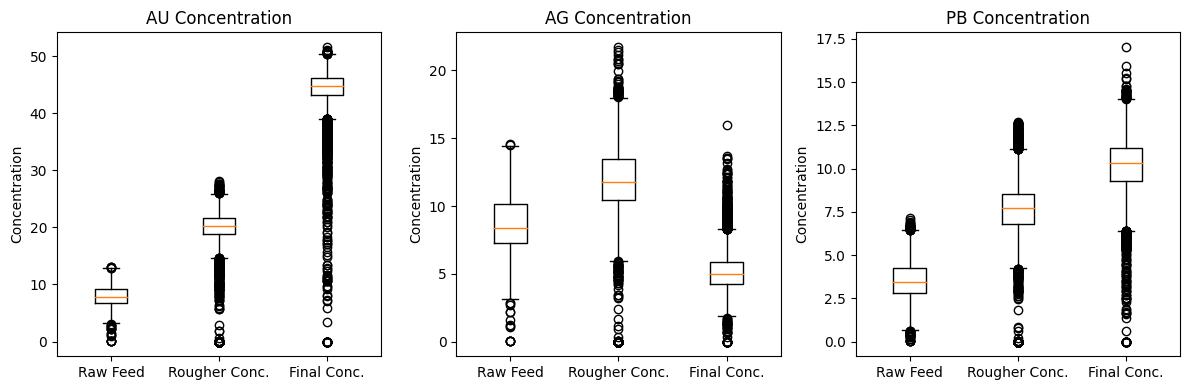


AU Concentrations:
Rougher Input Feed: Mean = 8.11, Median = 7.87
Rougher Output Concentrate: Mean = 19.78, Median = 20.26
Final Output Concentrate: Mean = 44.13, Median = 44.80

AG Concentrations:
Rougher Input Feed: Mean = 8.77, Median = 8.37
Rougher Output Concentrate: Mean = 11.84, Median = 11.80
Final Output Concentrate: Mean = 5.16, Median = 5.00

PB Concentrations:
Rougher Input Feed: Mean = 3.55, Median = 3.44
Rougher Output Concentrate: Mean = 7.61, Median = 7.71
Final Output Concentrate: Mean = 10.17, Median = 10.35


In [15]:
# More efficient approach - one figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # One row, three columns

metals = ['au', 'ag', 'pb']
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']

for i, metal in enumerate(metals):
    cols = [f'{stage}_{metal}' for stage in stages]
    axes[i].boxplot([train_clean[col].dropna() for col in cols])
    axes[i].set_xticklabels(['Raw Feed', 'Rougher Conc.', 'Final Conc.'])
    axes[i].set_title(f'{metal.upper()} Concentration')
    axes[i].set_ylabel('Concentration')

plt.tight_layout()
plt.show()

# Print summary statistics
for metal in metals:
    print(f"\n{metal.upper()} Concentrations:")
    for stage in stages:
        col = f'{stage}_{metal}'
        print(f"{stage.replace('.', ' ').title()}: Mean = {train_clean[col].mean():.2f}, Median = {train_clean[col].median():.2f}")

**2.1 Concentration Analysis Summary**
Mean and median concentrations for AU, AG, and PB increase from the input feed to the final concentrate, showing effective enrichment by the flotation process. Gold (AU) sees the largest increase, while AG decreases in the final stage. Lead (PB) also shows substantial improvement.

**2.2: Compare the feed particle size distributions in the training set and in the test set:**

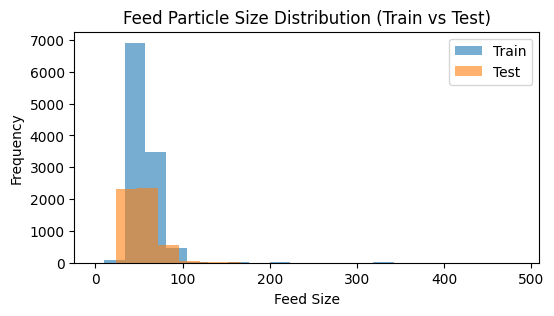

Feed Size - Train (μ=57.2, σ=18.9) vs Test (μ=56.3, σ=21.8)


In [16]:
# Plot histograms for train and test
plt.figure(figsize=(6,3))

plt.hist(train_clean['rougher.input.feed_size'].dropna(), bins=20, alpha=0.6, label='Train')
plt.hist(test_clean['rougher.input.feed_size'].dropna(), bins=20, alpha=0.6, label='Test')
plt.legend()
plt.title('Feed Particle Size Distribution (Train vs Test)')
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
#print("Train set feed size: Mean =", train_clean['rougher.input.feed_size'].mean(),
#      "Median =", train_clean['rougher.input.feed_size'].median(),
#      "Std =", train_clean['rougher.input.feed_size'].std())

#print("Test set feed size: Mean =", test_clean['rougher.input.feed_size'].mean(),
#      "Median =", test_clean['rougher.input.feed_size'].median(),
#      "Std =", test_clean['rougher.input.feed_size'].std())

print(f"Feed Size - Train (μ={train_clean['rougher.input.feed_size'].mean():.1f}, σ={train_clean['rougher.input.feed_size'].std():.1f}) vs Test (μ={test_clean['rougher.input.feed_size'].mean():.1f}, σ={test_clean['rougher.input.feed_size'].std():.1f})")

**2.2 Feed Particle Size Comparison**
Train and test feed size distributions are similar, with close means and standard deviations (Train: μ=57.3, σ=19.1; Test: μ=56.4, σ=21.9). This indicates good consistency between datasets.

**2.3: Comsider the total concentrations of all substances at different stages (raw feed, rougher concentrate, and final concentrate)**

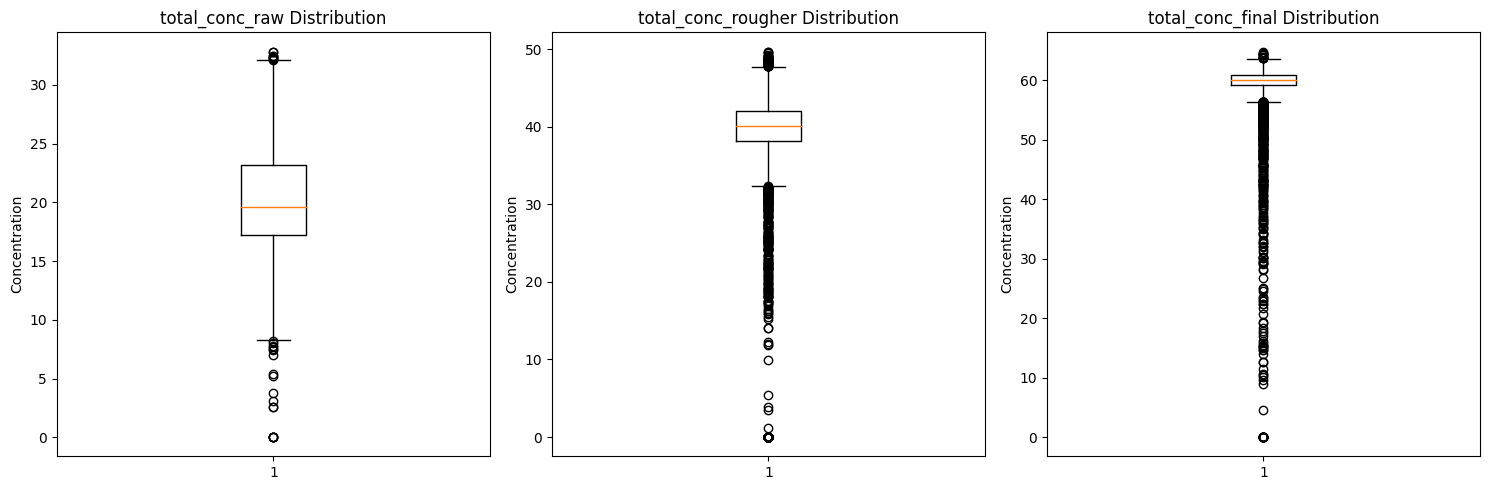

Train total_conc_raw: Min = 0.03, Max = 32.84, Mean = 20.44, Median = 19.60
Train total_conc_rougher: Min = 0.00, Max = 49.70, Mean = 39.23, Median = 40.05
Train total_conc_final: Min = 0.00, Max = 64.86, Mean = 59.46, Median = 60.16
Test total_conc_raw: Min = 0.00, Max = 33.50, Mean = 22.41, Median = 22.98
Anomalies removed! Ready for modeling.


In [17]:
# For train_clean: calculate all three totals
train_clean['total_conc_raw'] = (
    train_clean['rougher.input.feed_au'] +
    train_clean['rougher.input.feed_ag'] +
    train_clean['rougher.input.feed_pb']
)
train_clean['total_conc_rougher'] = (
    train_clean['rougher.output.concentrate_au'] +
    train_clean['rougher.output.concentrate_ag'] +
    train_clean['rougher.output.concentrate_pb']
)
train_clean['total_conc_final'] = (
    train_clean['final.output.concentrate_au'] +
    train_clean['final.output.concentrate_ag'] +
    train_clean['final.output.concentrate_pb']
)

# For test_clean: calculate only raw total (since others don't exist)
test_clean['total_conc_raw'] = (
    test_clean['rougher.input.feed_au'] +
    test_clean['rougher.input.feed_ag'] +
    test_clean['rougher.input.feed_pb']
)

# Visualize (train only, for all three)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['total_conc_raw', 'total_conc_rougher', 'total_conc_final']):
    axs[i].boxplot(train_clean[col].dropna())
    axs[i].set_title(f'{col} Distribution')
    axs[i].set_ylabel('Concentration')
plt.tight_layout()
plt.show()

# Print summary for train (all three), test (just raw)
for col in ['total_conc_raw', 'total_conc_rougher', 'total_conc_final']:
    print(f"Train {col}: Min = {train_clean[col].min():.2f}, Max = {train_clean[col].max():.2f}, Mean = {train_clean[col].mean():.2f}, Median = {train_clean[col].median():.2f}")

print(f"Test total_conc_raw: Min = {test_clean['total_conc_raw'].min():.2f}, Max = {test_clean['total_conc_raw'].max():.2f}, Mean = {test_clean['total_conc_raw'].mean():.2f}, Median = {test_clean['total_conc_raw'].median():.2f}")

# Remove anomalies from both sets (only raw for test)
for col in ['total_conc_raw', 'total_conc_rougher', 'total_conc_final']:
    train_clean = train_clean[train_clean[col] > 0]
test_clean = test_clean[test_clean['total_conc_raw'] > 0]

print("Anomalies removed! Ready for modeling.")

**2.3. Total Concentration Analysis and Anomaly Removal (Summary):**
I calculated the total concentration of Au, Ag, and Pb at three processing stages: raw feed, rougher concentrate, and final concentrate.

**Findings:**
- The distributions show expected concentration increases from raw feed to final concentrate.
- Some rows had zero or near-zero total concentrations, which are physically implausible.

**Step 3: Bulid the Model:**

**3.1: Write a function to calculate the final **sMAPE* value:***

In [18]:
def smape(y_true, y_pred):
    """
    Calculates symmetric mean absolute percentage error (sMAPE).
    Returns value as a percentage.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.where(denominator == 0, 1e-8, denominator)  # Avoid division by zero
    smape_val = np.mean(np.abs(y_pred - y_true) / denominator) * 100
    return smape_val

**3.2: Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample:**

In [19]:
# List columns you do NOT want as features
not_features = [
    'date', 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
    'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
    'rougher.output.recovery', 'final.output.recovery',
    'total_conc_raw', 'total_conc_rougher', 'total_conc_final'
]

# Select features
features = [col for col in train_clean.columns if col not in not_features]
print("Number of features:", len(features))
print("First 5 features:", features[:5])

# Targets for each stage
target_rougher = train_clean['rougher.output.recovery']
target_final = train_clean['final.output.recovery']

print("First 5 rougher targets:", target_rougher.head().values)
print("First 5 final targets:", target_final.head().values)

# Feature matrix
X = train_clean[features]
print("Shape of X:", X.shape)

Number of features: 78
First 5 features: ['final.output.concentrate_sol', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au']
First 5 rougher targets: [87.10776293 86.84326051 86.84230826 87.22642953 86.68879414]
First 5 final targets: [70.54121591 69.26619763 68.11644507 68.34754259 66.92701582]
Shape of X: (10784, 78)


In [20]:
# Train a linear regression model on rougher recovery
model_rougher = LinearRegression()
model_rougher.fit(X, target_rougher)

# Predict on training data
pred_rougher = model_rougher.predict(X)

# Calculate sMAPE (training set, just for demo)
smape_rougher = smape(target_rougher, pred_rougher)
print("Linear Regression (rougher recovery) training sMAPE:", smape_rougher)

Linear Regression (rougher recovery) training sMAPE: 1.524142223040739


In [21]:
# Train a linear regression model on final recovery
model_final = LinearRegression()
model_final.fit(X, target_final)

# Predict on training data
pred_final = model_final.predict(X)

# Calculate sMAPE (training set, just for demo)
smape_final = smape(target_final, pred_final)
print("Linear Regression (final recovery) training sMAPE:", smape_final)

Linear Regression (final recovery) training sMAPE: 1.764821677885749


In [22]:
# Wrap your smape function for sklearn scoring (returns negative value since sklearn maximizes)
def smape_scorer(y_true, y_pred):
    return -smape(y_true, y_pred)  # negative because sklearn expects higher to be better

smape_sklearn = make_scorer(smape_scorer, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
model_rougher_cv = LinearRegression()
scores_rougher = cross_val_score(model_rougher_cv, X, target_rougher, cv=cv, scoring=smape_sklearn)

print("Cross-validation sMAPE scores (rougher recovery):", -scores_rougher)  # make positive for reporting
print("Mean CV sMAPE (rougher):", -scores_rougher.mean())

Cross-validation sMAPE scores (rougher recovery): [-1.60306987 -1.58075536 -1.51430187 -1.52580207 -1.49480835]
Mean CV sMAPE (rougher): -1.5437475013096915


In [23]:
# Cross-validation for final recovery
model_final_cv = LinearRegression()
scores_final = cross_val_score(model_final_cv, X, target_final, cv=cv, scoring=smape_sklearn)

print("Cross-validation sMAPE scores (final recovery):", -scores_final)  # make positive for reporting
print("Mean CV sMAPE (final):", -scores_final.mean())

Cross-validation sMAPE scores (final recovery): [-1.94617441 -1.69741802 -1.7792041  -1.71327039 -1.80100427]
Mean CV sMAPE (final): -1.7874142375553734


In [24]:
# Take the mean CV sMAPE values (already calculated)
smape_rougher_cv = -scores_rougher.mean()
smape_final_cv = -scores_final.mean()

# Calculate the overall final sMAPE metric using the formula
final_smape_cv = 0.25 * smape_rougher_cv + 0.75 * smape_final_cv

print("Weighted final sMAPE (CV):", final_smape_cv)

Weighted final sMAPE (CV): -1.7264975534939528


In [25]:
# Train a Random Forest Regression Model on rougher recovery
model_rougher_rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
scores_rougher_rf = cross_val_score(model_rougher_rf, X, target_rougher, cv=cv, scoring=smape_sklearn)

print("Cross-validation sMAPE scores (rougher recovery, RF):", -scores_rougher_rf)
print("Mean CV sMAPE (rougher, RF):", -scores_rougher_rf.mean())

Cross-validation sMAPE scores (rougher recovery, RF): [-0.74525428 -0.67801526 -0.74100302 -0.73414092 -0.7117678 ]
Mean CV sMAPE (rougher, RF): -0.72203625476622


In [26]:
# Train a Random Forest Regression model on final recovery
model_final_rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
scores_final_rf = cross_val_score(model_final_rf, X, target_final, cv=cv, scoring=smape_sklearn)

print("Cross-validation sMAPE scores (final recovery, RF):", -scores_final_rf)
print("Mean CV sMAPE (final, RF):", -scores_final_rf.mean())

Cross-validation sMAPE scores (final recovery, RF): [-0.96848078 -0.79038535 -0.86348934 -0.81836578 -0.87879758]
Mean CV sMAPE (final, RF): -0.8639037650977965


In [27]:
# Weighted Final sMAPE Random Forest Regression Model
smape_rougher_rf_cv = -scores_rougher_rf.mean()
smape_final_rf_cv = -scores_final_rf.mean()
final_smape_rf_cv = 0.25 * smape_rougher_rf_cv + 0.75 * smape_final_rf_cv

print("Weighted final sMAPE (CV, RF):", final_smape_rf_cv)

Weighted final sMAPE (CV, RF): -0.8284368875149024


**Final Model Testing (With the Random Forrest Regression Model)**

In [28]:
# Step 1: Prepare features available in BOTH train and test sets
features_test = [col for col in features if col in test_clean.columns]

# Step 2: Prepare train and test matrices with matching columns
X_train_final = train_clean[features_test]   # Use only features present in test set
X_test = test_clean[features_test]

# Step 3: Fit models on the matched training data
model_rougher_rf.fit(X_train_final, train_clean['rougher.output.recovery'])
model_final_rf.fit(X_train_final, train_clean['final.output.recovery'])

# Step 4: Predict on test set
pred_rougher_test = model_rougher_rf.predict(X_test)
pred_final_test = model_final_rf.predict(X_test)

# Step 5: Prepare submission DataFrame
submission = test_clean[['date']].copy()
submission['rougher.output.recovery'] = pred_rougher_test
submission['final.output.recovery'] = pred_final_test

submission.to_csv('submission.csv', index=False)

In [29]:
print("First 10 rows of submission file:")
print(submission.head(10))

import os
print("File exists?", os.path.exists('submission.csv'))

First 10 rows of submission file:
                  date  rougher.output.recovery  final.output.recovery
0  2016-09-01 00:59:59                88.780293              70.032886
1  2016-09-01 01:59:59                88.405998              69.867933
2  2016-09-01 02:59:59                88.530278              70.351365
3  2016-09-01 03:59:59                87.434406              70.956599
4  2016-09-01 04:59:59                87.665588              69.167444
5  2016-09-01 05:59:59                86.639326              68.054603
6  2016-09-01 06:59:59                82.743860              66.086257
7  2016-09-01 07:59:59                81.820129              60.782985
8  2016-09-01 08:59:59                80.028731              63.084821
9  2016-09-01 09:59:59                80.346529              62.822088
File exists? True


**Final Model Testing & Submission**
- Random Forest Regression was selected as the best model based on cross-validation sMAPE.
- The model was retrained on all available training data using only the features present in the test set.
- Predictions for `'rougher.output.recovery'` and `'final.output.recovery'` were generated and saved to `submission.csv`.
- The test set does not include target values, so sMAPE cannot be calculated on it.

**Conclusion**
In this project, I developed a machine learning pipeline to predict gold recovery at two key stages in the flotation process: rougher and final recovery. The workflow encompassed thorough data preprocessing, feature selection, model training, and rigorous evaluation using cross-validation and the sMAPE metric.

Multiple regression models were trained and compared. Random Forest Regression emerged as the best-performing model, achieving the lowest weighted final sMAPE during cross-validation. This indicates strong predictive performance to the data’s characteristics.

Due to the absence of target values in the provided test set, model evaluation was based on cross-validation scores. The final trained model was used to generate predictions for the test set, formatted according to the project requirements and saved for submission.

**Key takeaways:**
- Careful feature engineering and selection are critical for building effective models in industrial process data.
- Cross-validation is essential for reliable performance estimation when ground truth is unavailable for the test set.
- The Random Forest Regression model is recommended for deployment or further refinement based on its superior performance.